In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from fedXGBclass import XGBoostFederated
from sklearn.model_selection import train_test_split

## 1) Telco dataset

**Binary predicition** task (churn), cca 7000 observations.

Link: https://www.kaggle.com/blastchar/telco-customer-churn

### 1.1) Data import and preprocessing

In [2]:
data = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
data['TotalCharges'] = data['TotalCharges'].replace(" ", 0).astype('float32')
categorical_cols = list(set(list(data.columns)) - set(['tenure', 'MonthlyCharges', 'TotalCharges', 'customerID']))
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
data.TotalCharges = pd.to_numeric(data['TotalCharges'],errors='coerce')

In [3]:
data.head()

,customerID,tenure,MonthlyCharges,TotalCharges,gender_Male,DeviceProtection_No internet service,DeviceProtection_Yes,MultipleLines_No phone service,MultipleLines_Yes,StreamingTV_No internet service,...,OnlineBackup_Yes,PhoneService_Yes,Partner_Yes,SeniorCitizen_1,StreamingMovies_No internet service,StreamingMovies_Yes,TechSupport_No internet service,TechSupport_Yes,Dependents_Yes,PaperlessBilling_Yes
0,7590-VHVEG,1,29.85,29.850000,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,1
1,5575-GNVDE,34,56.95,1889.500000,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,3668-QPYBK,2,53.85,108.150002,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
3,7795-CFOCW,45,42.30,1840.750000,1,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,9237-HQITU,2,70.70,151.649994,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [4]:
data.shape

(7043, 32)

In [5]:
X_telco, y_telco = data.loc[:, ~data.columns.isin(['Churn_Yes', 'customerID'])], data.Churn_Yes

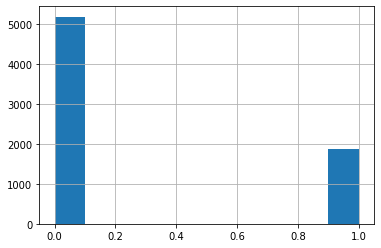

In [6]:
y_telco.hist()
plt.show()

### 1.2) Training

In [7]:
nr_iter_ = 20
test_train_split = 0.2
params_ = {'max_depth': 4, 'eta': 0.1, 'verbosity': 1, 'max_delta_step': 0,
                'scale_pos_weight': 1.5, 'objective': 'binary:logitraw',
                 'max_bin':250, 'nthread':-1}

fed_trees_model = XGBoostFederated(X_telco, y_telco, test_train_split)

### 1.2.1) Centralized

In [8]:
fed_trees_model_cent = fed_trees_model.train_centralized(params_, nr_iter_)

----------Centralized results(in-sample)----------
Accuracy 0.798
Baseline accuracy 0.7345
F1 score 0.6254
[[3546  592]
 [ 546  950]]
----------Centralized results(out-of-sample)----------
Accuracy 0.8176
Baseline accuracy 0.7353
F1 score 0.6658
[[896 140]
 [117 256]]


### 1.2.2) Federated - peer2peer

In [9]:
fed_trees_model_fed = fed_trees_model.train_federated(params_, nr_iter_, 1)

----------Federated results for node 1 (in-sample)----------
Accuracy 0.808
Baseline accuracy 0.7288
F1 score 0.648
[[1778  275]
 [ 266  498]]
----------Federated results for node 1 (out-of-sample)----------
Accuracy 0.8125
Baseline accuracy 0.7344
F1 score 0.6633
[[442  75]
 [ 57 130]]


Saving and loading xgboost models: https://stackoverflow.com/questions/43691380/how-to-save-load-xgboost-model

To preserve feature names, xgboost model object can also be pickled and send as a pickle file.

### 1.2.3) Local baseline

In [10]:
fed_trees_model_local = fed_trees_model.train_local(params_, nr_iter_, 1)

----------Baseline local results for node 1(in-sample)----------
Accuracy 0.8037
Baseline accuracy 0.7288
F1 score 0.652
[[1746  307]
 [ 246  518]]
----------Baseline local results for node 1(out-of-sample)----------
Accuracy 0.794
Baseline accuracy 0.7344
F1 score 0.631
[[435  82]
 [ 63 124]]


## 2) KKBox dataset

**Binary prediction** (churn), cca 1 million observations.

Link: https://www.kaggle.com/c/kkbox-churn-prediction-challenge/data

Strange thing about this dataset is that results (accuracy, f1 score) do not change much with different amount of data used to fit the model as well as with different number of trees (see old notebook, KKBox's churn data v2.ipynb, for examples)

### 2.1) Data import and preprocessing

In [11]:
data_kkbox = pd.read_csv("data/churn_prediction_v2_preprocessed.csv")
data_kkbox.drop(["msno"], axis=1, inplace=True)

In [12]:
data_kkbox.head()

,is_churn,city,bd,gender,registered_via,num_25_sum,num_50_sum,num_75_sum,num_985_sum,num_100_sum,...,14_city,15_city,16_city,17_city,18_city,19_city,20_city,21_city,22_city,registration_duration
0,1,5.0,28.0,1.0,3.0,186.0,23.0,13.0,10.0,318.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,13.0,20.0,1.0,3.0,0.0,4.0,2.0,0.0,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1205.0
2,1,13.0,18.0,1.0,3.0,239.0,57.0,32.0,22.0,205.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1266.0
3,1,1.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1460.0
4,1,13.0,35.0,-1.0,7.0,9.0,7.0,4.0,4.0,962.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1332.0


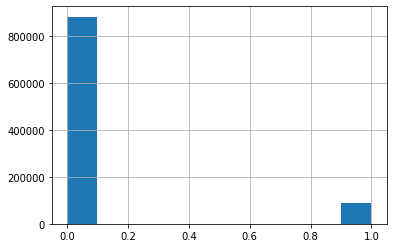

In [13]:
data_kkbox.is_churn.hist()
plt.show()

In [14]:
data_kkbox.shape

(970960, 62)

### 2.2) Training

In [15]:
params_kkbox = {'max_depth': 4, 'eta': 0.1, 'verbosity': 1, 'max_delta_step': 0,
                'scale_pos_weight': 1.5, 'objective': 'binary:logitraw',
                    'tree_method':'hist', 'max_bin':10, 'nthread':-1}
nr_iter_kkbox = 10

In [16]:
#shuffle data
data_kkbox = data_kkbox.sample(frac=1)

X_kkbox, y_kkbox = data_kkbox.loc[:, ~data_kkbox.columns.isin(['is_churn'])], data_kkbox.is_churn

In [17]:
fed_trees_model_kkbox = XGBoostFederated(X_kkbox, y_kkbox)

### 2.2.1) Centralized

In [18]:
fed_trees_model_kkbox_center = fed_trees_model_kkbox.train_centralized(params_kkbox, nr_iter_kkbox)

KeyboardInterrupt: 

### 2.2.2) Federated - peer2peer

In [ ]:
fed_trees_model_kkbox_fed = fed_trees_model_kkbox.train_federated(params_kkbox, nr_iter_kkbox, 1)

### 2.2.3) Local baseline

In [ ]:
fed_trees_model_kkbox_local = fed_trees_model_kkbox.train_local(params_kkbox, nr_iter_kkbox, 1)

## 3) Peer2peer

- plain peer2peer: all local data used in every iteration
- peer2peer using batches: train in bathces, only one batch of local data used per iteration
- peer2peer with NoiseFirst: before training, clients locally add diff. private noise to their data
- peer2peer with random order
- peer2peer with monitoring the accuracy and terminating training once accuracy is no longer improved. Also checking that each client is contributing, i.e. that each tree is informative
- peer2peer with different data splits, e.g. one client has 70% of data and the other has 30% of data

## 4) New functions (multiple nodes support)

In [ ]:
fed_trees_model_v2 = XGBoostFederated(X_telco, y_telco, test_train_split)

In [ ]:
fed_trees_model_fed_v2 = fed_trees_model_v2.train_federated_v2(params_, nr_iter_, 1)

In [ ]:
fed_trees_model_local_v2 = fed_trees_model_v2.train_local_v2(params_, nr_iter_, 1)